In [45]:
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm
import torch
import numpy as np
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
import pandas as pd
from lag_llama.gluon.estimator import LagLlamaEstimator

### define the prediction func

In [2]:
def get_lag_llama_predictions(dataset, 
                              prediction_length, 
                              context_length=32, 
                              num_samples=20, 
                              device="cuda", 
                              batch_size=64, 
                              nonnegative_pred_samples=True):
    
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },
        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

### load dataset: trajectory 1 from train_FD001

In [56]:
# take  as example
df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/train_FD001.txt', index_col=0, sep=" ", header=None)
column_indices = np.arange(df.shape[1]-1).tolist()

index_columns_names =  ["cycle"]
op_settings_columns = ["op_setting_"+str(i) for i in range(1,4)]
sensor_columns =["sensor_"+str(i) for i in range(1,22)]
new_names = index_columns_names + op_settings_columns + sensor_columns

old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.index.names = ['engine']
df.drop([26, 27], axis=1, inplace=True)
df_sensor = df.drop(['op_setting_1', 'op_setting_2', 'op_setting_3'], axis=1) 
df_sensor_top1 = df_sensor[df_sensor.index==1]

# df_sensor_top1 = df_sensor_top1.drop(['cycle'], axis=1)

df_sensor_top1 = df_sensor_top1.set_index('cycle')
df_sensor_top1.index = pd.to_datetime(df_sensor_top1.index, origin='1970-01-01', unit='h')
df_sensor_top1
## df_sensor_top1 = df_sensor_top1.reset_index(drop=True)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
cycle,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:00:00,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1970-01-01 02:00:00,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
1970-01-01 03:00:00,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
1970-01-01 04:00:00,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
1970-01-01 05:00:00,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-08 20:00:00,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,2388.31,9037.91,1.3,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
1970-01-08 21:00:00,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,2388.27,9044.55,1.3,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
1970-01-08 22:00:00,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675


In [46]:
# convert df to training and testing datasets

train_data = [{"start": df_sensor_top1.index[0], "target": df_sensor_top1[i].values[:-prediction_length]} for i in df_sensor_top1.columns]
test_data = [{"start": df_sensor_top1.index[0], "target": df_sensor_top1[i].values} for i in df_sensor_top1.columns]

train_ds = ListDataset(data_iter=train_data, freq='1H') # training dataset
test_ds = ListDataset(data_iter=test_data, freq='1H') # testing dataset

### Zero-shot forecasting

In [29]:
prediction_length = 24 # default
num_samples = 100 # default
context_length = 128 # use 128 cos it achieves lowest CRPS in Zero-shot notebook
device = "cpu"
# use rope_scaling by default, no need to specify

In [49]:
forecasts, tss = get_lag_llama_predictions(
    # dataset.test,
    test_ds, # since it's zero-shot forecasting, it's same to testing
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length, 
    device=device
)

Ground truth: 100%|██████████| 21/21 [00:00<00:00, 11115.65it/s]


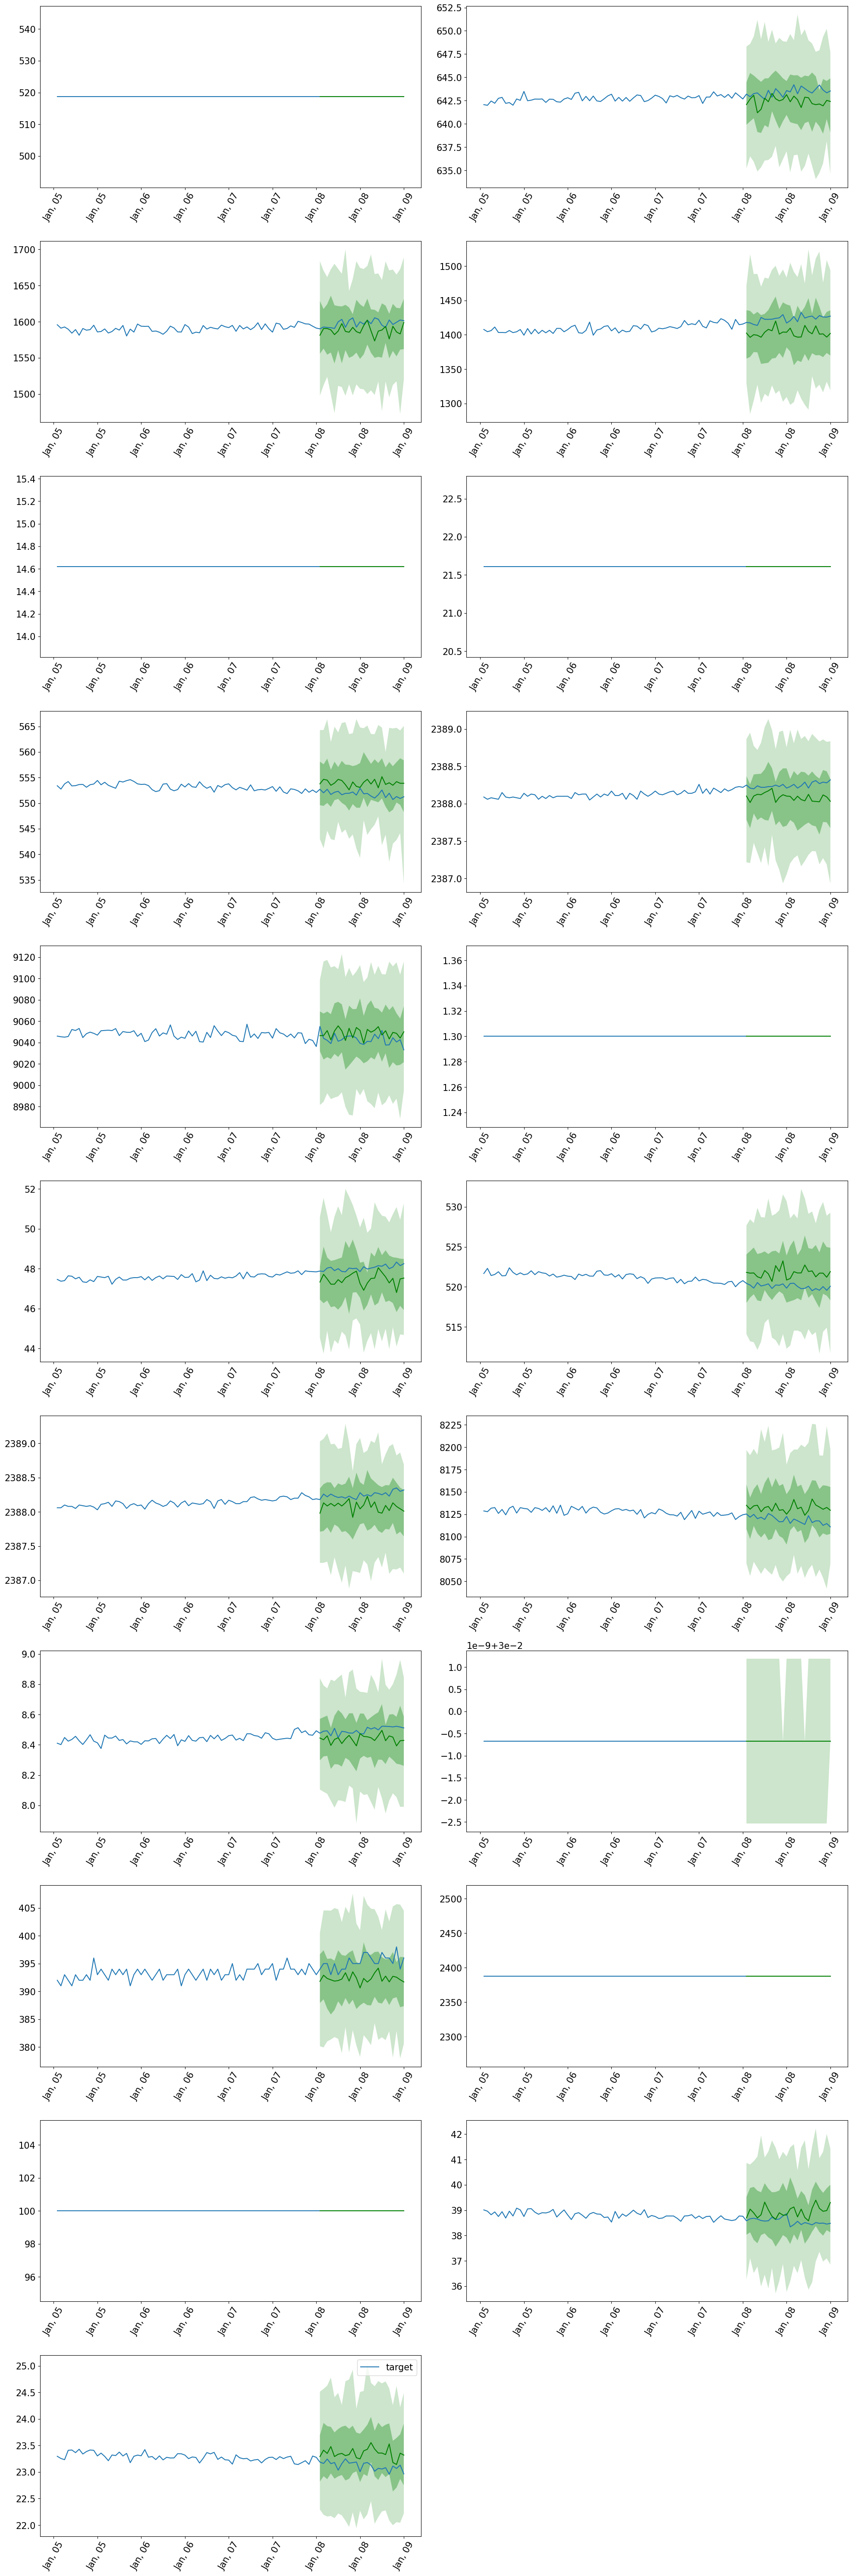

In [50]:
plt.figure(figsize=(20, 60))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 21):
    ax = plt.subplot(11, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [51]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])
# CRPS: 0.0020124491499736606

Running evaluation: 21it [00:00, 394.59it/s]


CRPS: 0.0020369086078513357


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: Run

### Fine-tuning

In [59]:
# get_dataset()

##ckpt = torch.load("lag-llama.ckpt", map_location=device)
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4, # training params

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },  why comment out?

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 10,}, # <- lightning trainer arguments
    )

In [60]:
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:34<00:00,  1.47it/s, v_num=2]

Epoch 0, global step 50: 'train_loss' reached 4.84610 (best 4.84610), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:33<00:00,  1.47it/s, v_num=2]

Epoch 1, global step 100: 'train_loss' reached 2.74516 (best 2.74516), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:34<00:00,  1.47it/s, v_num=2]

Epoch 2, global step 150: 'train_loss' reached 2.45089 (best 2.45089), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:33<00:00,  1.50it/s, v_num=2]

Epoch 3, global step 200: 'train_loss' reached 2.26069 (best 2.26069), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:33<00:00,  1.50it/s, v_num=2]

Epoch 4, global step 250: 'train_loss' reached 1.94642 (best 1.94642), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:33<00:00,  1.50it/s, v_num=2]

Epoch 5, global step 300: 'train_loss' reached 1.79843 (best 1.79843), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:38<00:00,  1.29it/s, v_num=2]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:36<00:00,  1.38it/s, v_num=2]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:35<00:00,  1.43it/s, v_num=2]

Epoch 8, global step 450: 'train_loss' reached 1.78199 (best 1.78199), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_2/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:35<00:00,  1.41it/s, v_num=2]

Epoch 9, global step 500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:35<00:00,  1.41it/s, v_num=2]


In [66]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=num_samples
    )
# forecasts = list(tqdm(forecast_it, total=len(test_ds)+len(train_ds), desc="Forecasting batches"))
# tss = list(tqdm(ts_it, total=len(test_ds)+len(train_ds), desc="Ground truth"))

In [67]:
forecasts = list(forecast_it)
tss = list(ts_it)

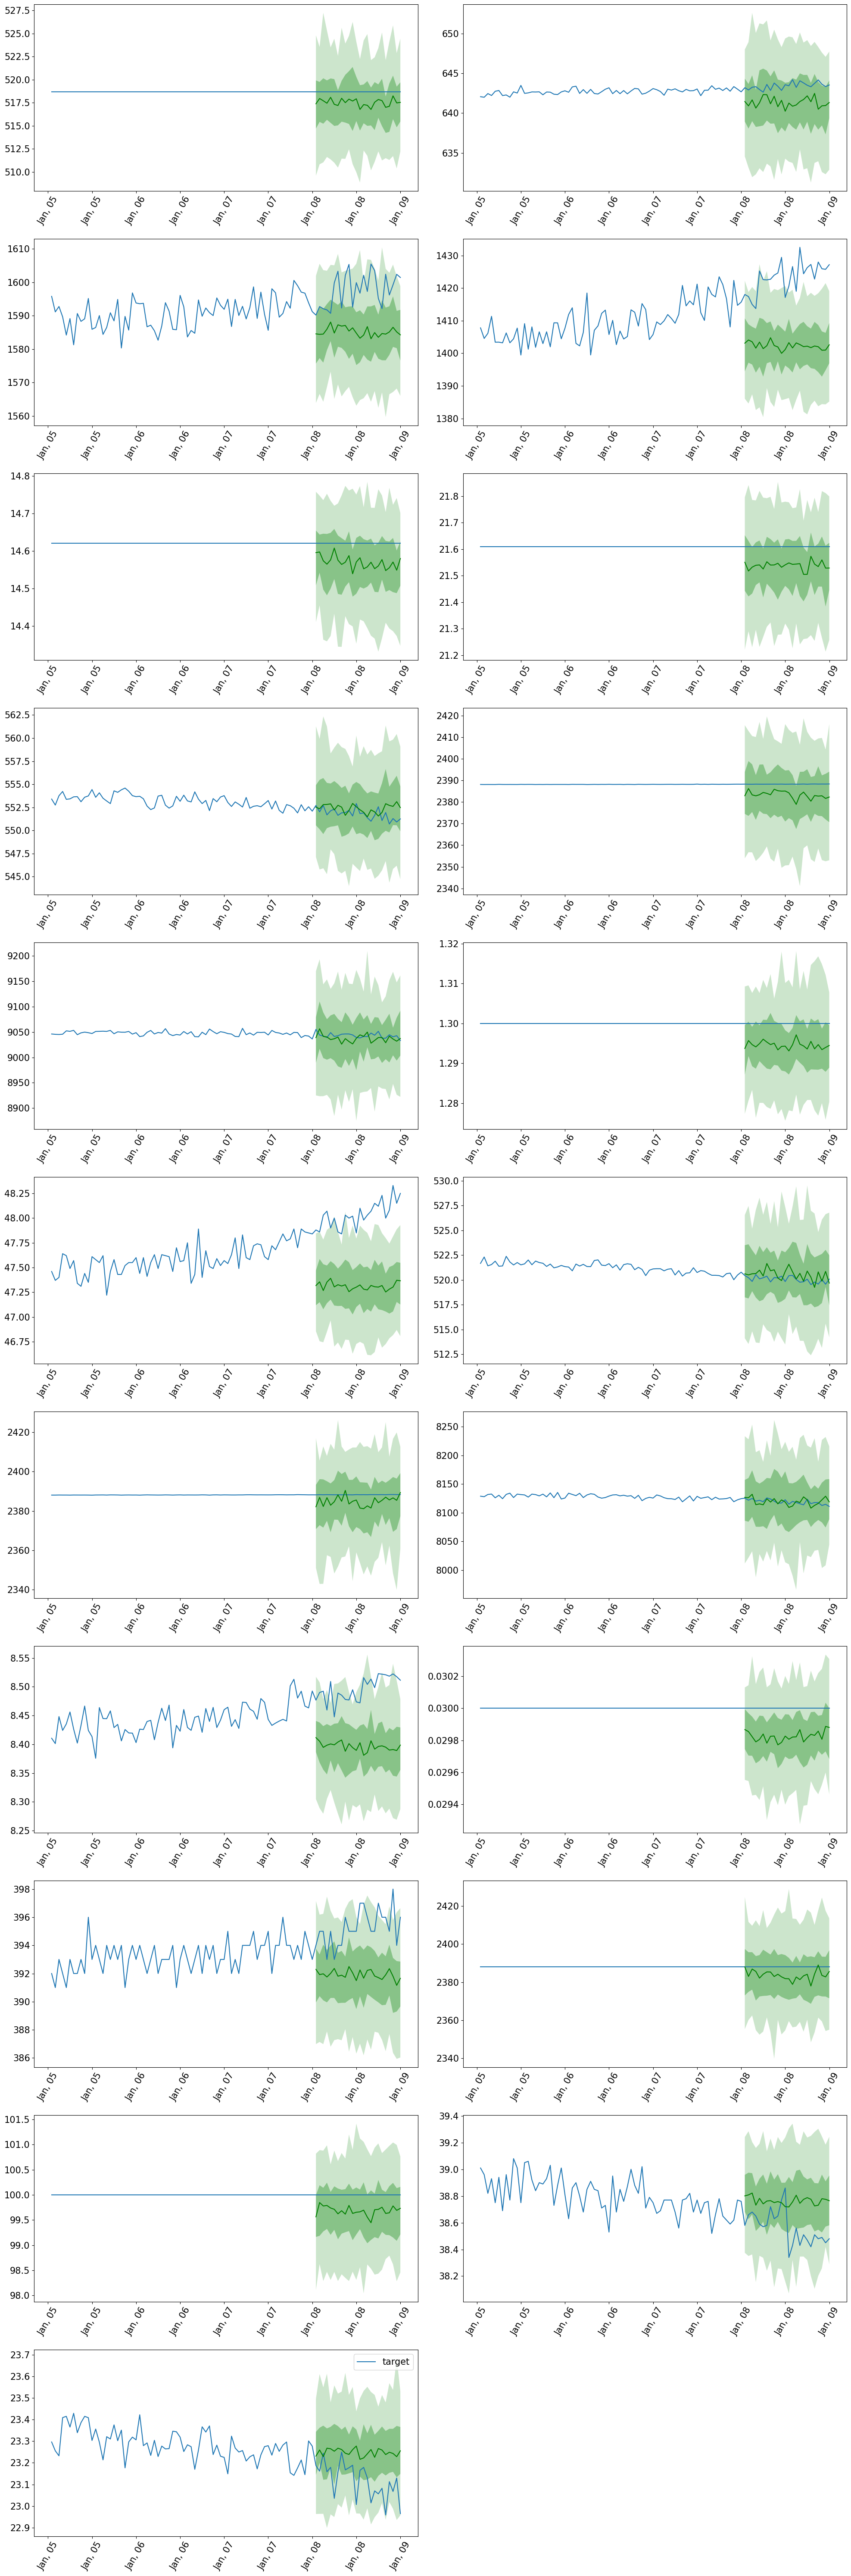

In [68]:
plt.figure(figsize=(20, 60))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 21):
    ax = plt.subplot(11, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [73]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 21it [00:00, 253.25it/s]


CRPS: 0.00267409510480394


/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:154: 

In [74]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.00267409510480394


- why is the CRPS result from fine-tuning even worse than from zeo-shot forecasting?
- evaluator for fine-tuning always raises error, fails to get CRPS scores.
- why are the zero-shot forecasts for static features (constant values) 100% accurate? and why are forecasts for fine-tuned static features so bad?
- 
- the time series data for a specific sensor don't end at the same time, how to form them into a table? 

### Training datasets
For zero-shot forecasting (inference), we can pass in all the time series (from 1-21) all at once and the model outputs forecasts separately. For training and fine-tuning the univariate time series forecasting model, the datasets should be sensor-specific. 
- Row: timestamps in H, 
- Columns: #trajectories 

Problem: 
- How to deal with the fact that trajectories for the same sensor don't end at the same time? Truncate/Padding
how should the traning set be like? esp. when we have so many trajectories: train 1-4: 100, 260, 100, 248